Preprocessing Data

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

In [2]:
X = np.load('Data/X_train.npy')
y = np.load('Data/Y_train.npy')
print("X.shape =", X.shape, "y.shape =", y.shape)

X.shape = (700, 6) y.shape = (700,)


In [3]:
X_scaled = StandardScaler().fit_transform(X)
print("means:", np.round(X_scaled.mean(axis=0), 4))
print("stds: ", np.round(X_scaled.std(axis=0), 4))

means: [-0. -0.  0.  0.  0. -0.]
stds:  [1. 1. 1. 1. 1. 1.]


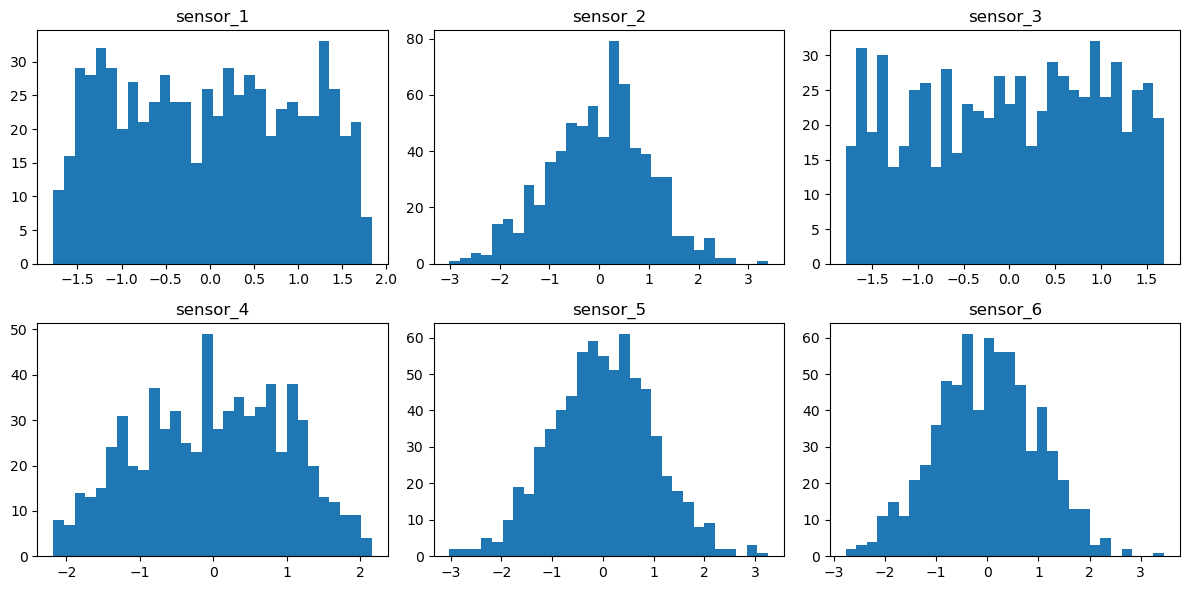

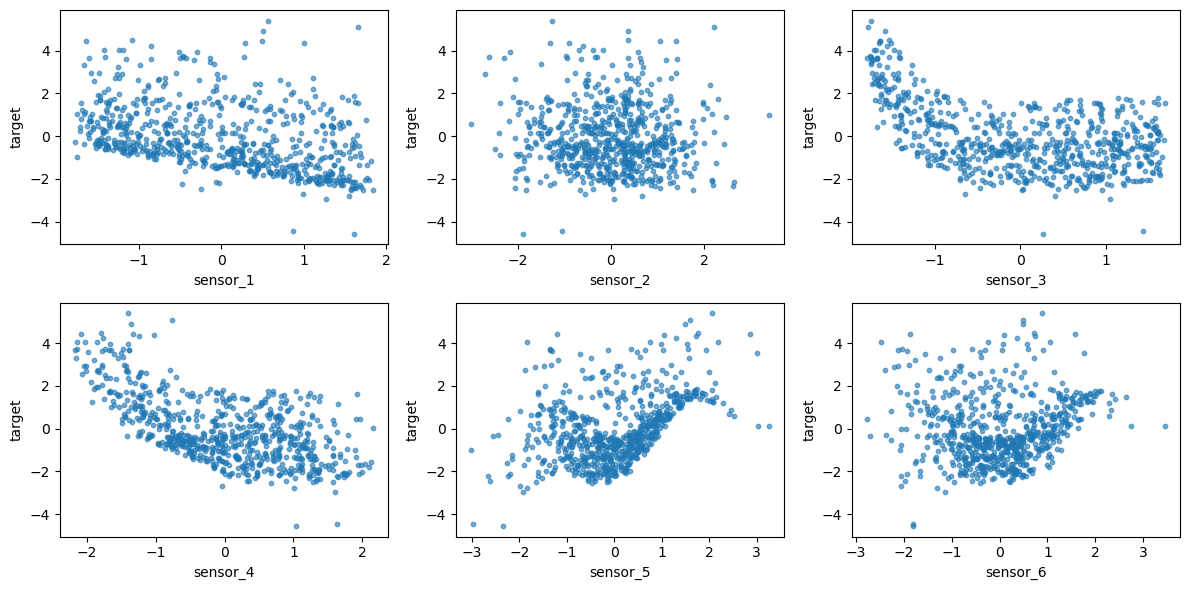

In [4]:
import matplotlib.pyplot as plt

# histograms
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, ax in enumerate(axes.ravel()):
    ax.hist(X_scaled[:, i], bins=30)
    ax.set_title(f"sensor_{i+1}")
plt.tight_layout()
plt.show()

# scatter each feature vs target
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, ax in enumerate(axes.ravel()):
    ax.scatter(X_scaled[:, i], y, s=10, alpha=0.6)
    ax.set_xlabel(f'sensor_{i+1}')
    ax.set_ylabel('target')
plt.tight_layout()
plt.show()


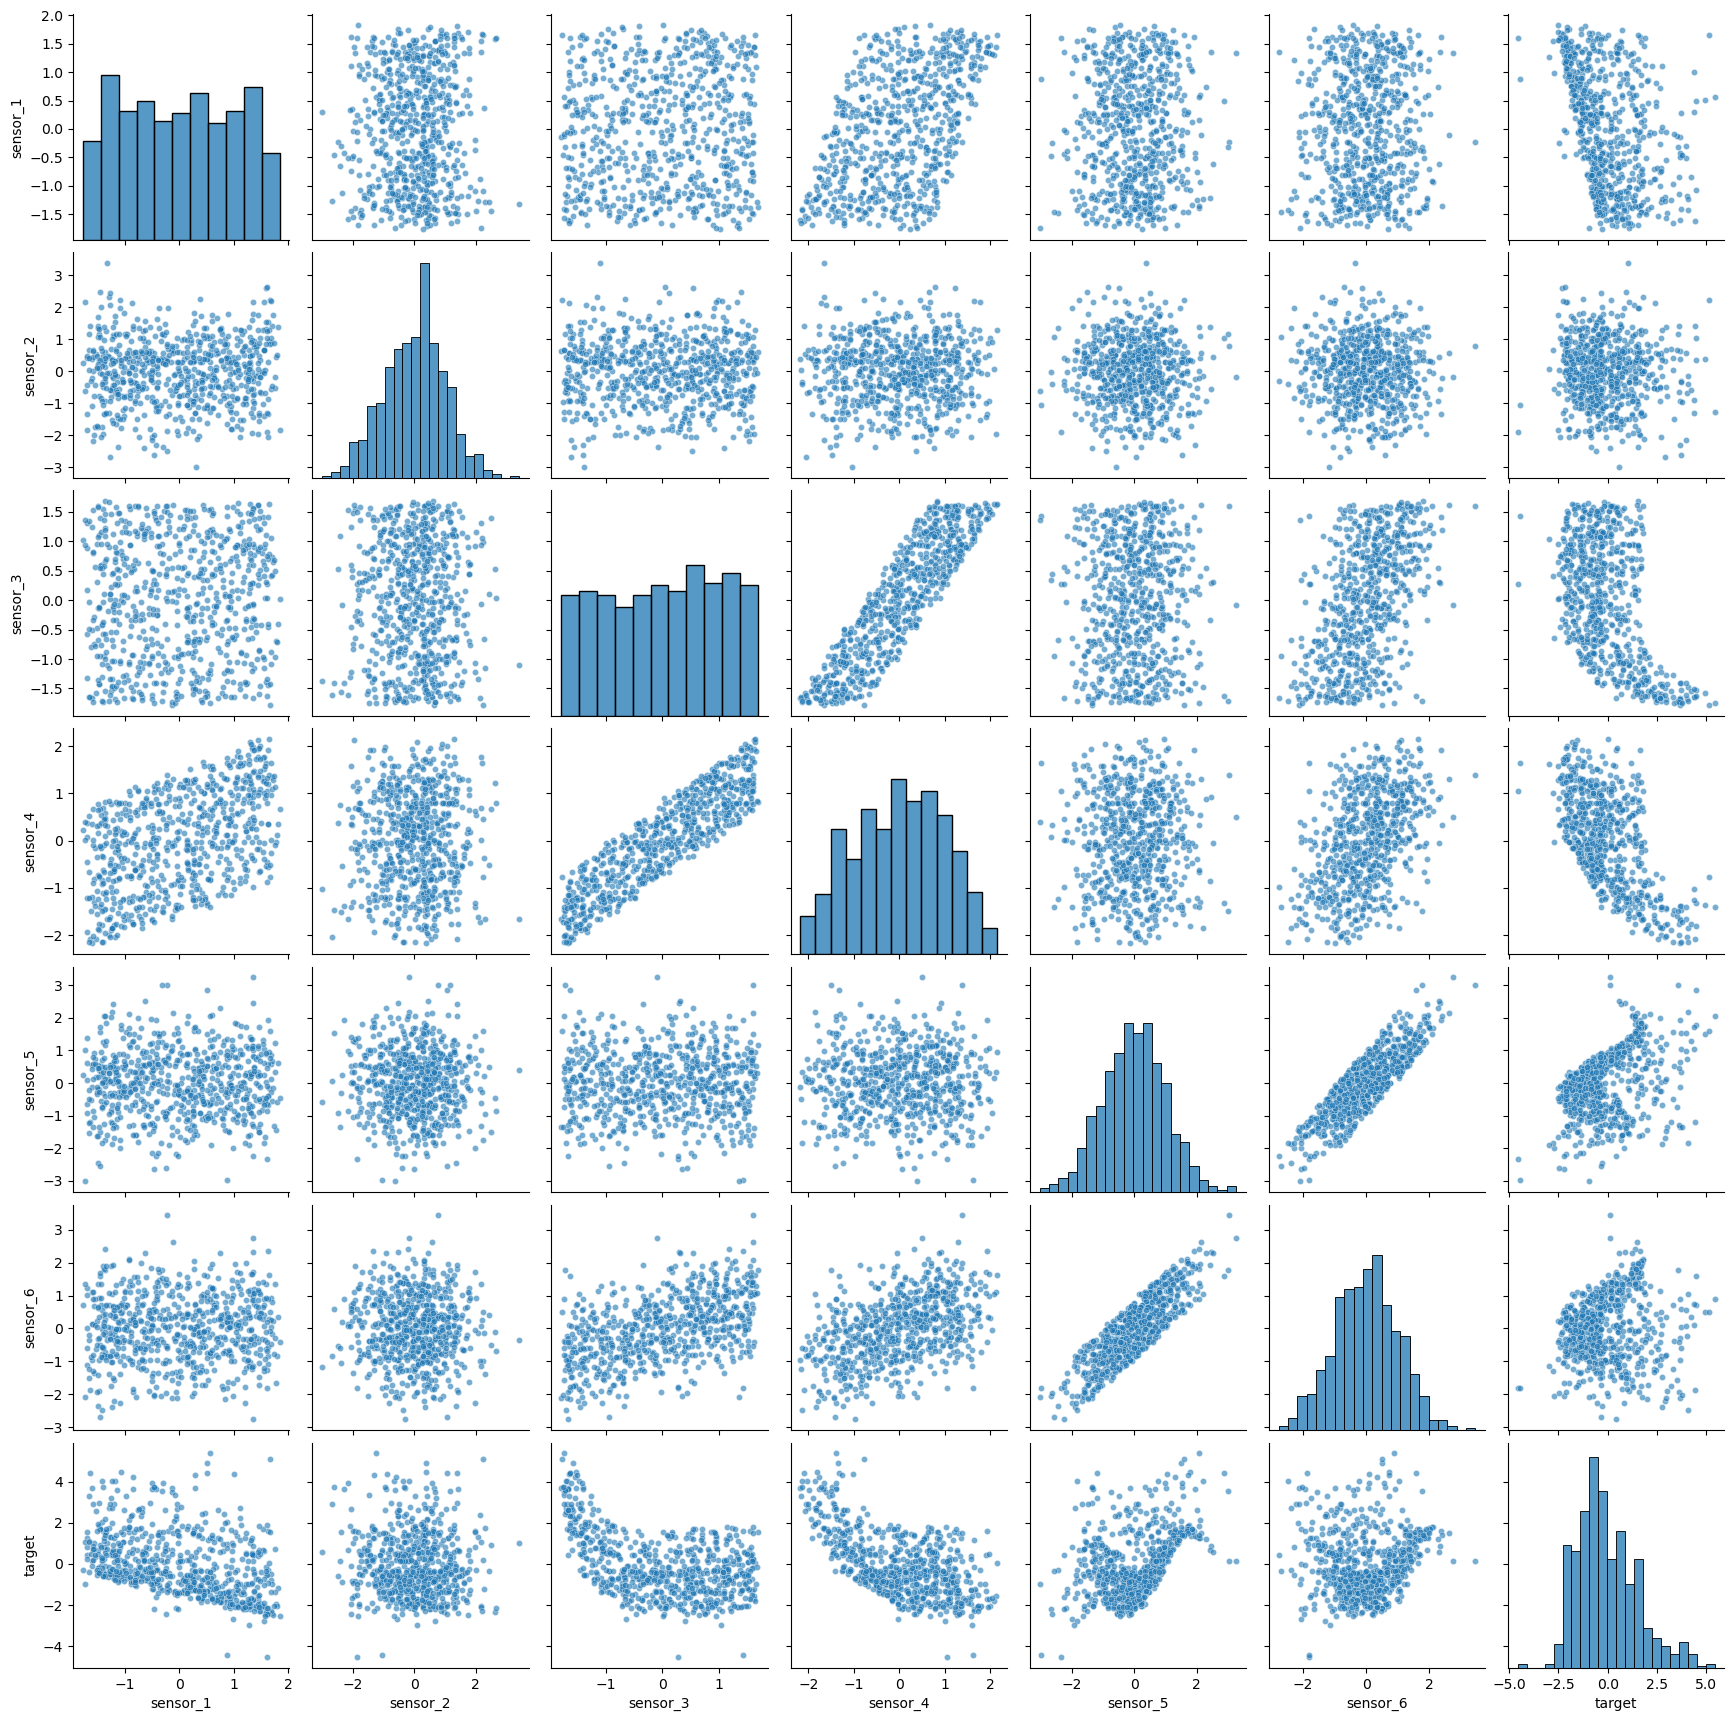

In [5]:
# Combine features and target into a DataFrame
df = pd.DataFrame(X_scaled, columns=[f'sensor_{i+1}' for i in range(X_scaled.shape[1])])
df['target'] = y

# Pairplot
sns.pairplot(df, diag_kind='hist', kind='scatter', plot_kws={'alpha':0.6, 's':20})
plt.show()


Feature vs target correlations (sorted by abs):
sensor_4    0.615151
sensor_3    0.498314
sensor_5    0.405033
sensor_1    0.402298
sensor_6    0.094479
sensor_2    0.050452
Name: target, dtype: float64


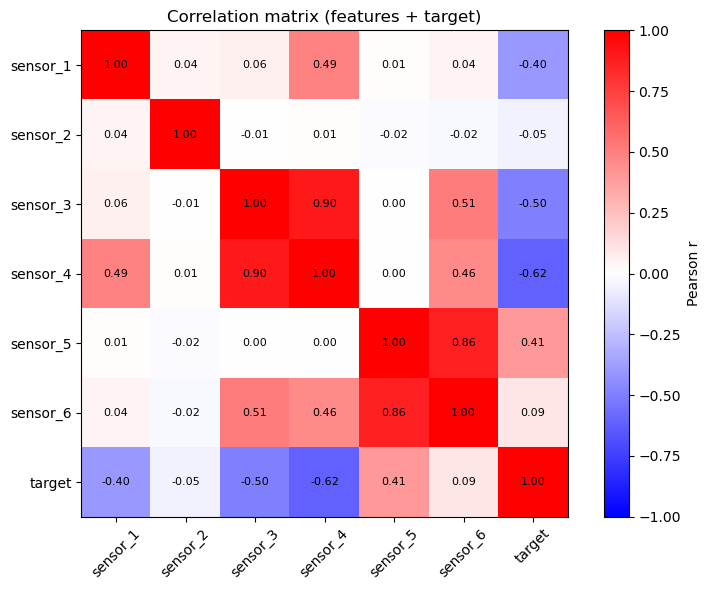

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colnames = [f"sensor_{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X_scaled, columns=colnames)
df['target'] = y

corr = df.corr()                     # Pearson correlation matrix
feat_target_corr = corr['target'].drop('target')  # feature vs target
print("Feature vs target correlations (sorted by abs):")
print(feat_target_corr.abs().sort_values(ascending=False))

# Visualize correlation matrix (with numeric annotations)
plt.figure(figsize=(8,6))
plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr', interpolation='nearest')
plt.colorbar(label='Pearson r')
ticks = np.arange(len(corr))
plt.xticks(ticks, corr.columns, rotation=45)
plt.yticks(ticks, corr.columns)
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', fontsize=8)
plt.title("Correlation matrix (features + target)")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)  # try 0.005..0.02
is_outlier_iso = iso.fit_predict(X_scaled) == -1
print("IsolationForest outliers:", is_outlier_iso.sum())


IsolationForest outliers: 7


In [8]:
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# --- Z-score ---
zs = np.abs(zscore(X_scaled))
z_thresh = 3.0
outlier_mask_z = (zs > z_thresh).any(axis=1)
print("Z-score outliers:", outlier_mask_z.sum())

# --- IsolationForest ---
iso = IsolationForest(contamination=0.01, random_state=42)
is_outlier_iso = iso.fit_predict(X_scaled) == -1
print("IsolationForest outliers:", is_outlier_iso.sum())

# --- Combinação ---
# União (qualquer método marca como outlier)
outlier_union = outlier_mask_z | is_outlier_iso
print("Outliers (union):", outlier_union.sum())

# Interseção (só se ambos concordam)
outlier_intersection = outlier_mask_z & is_outlier_iso
print("Outliers (intersection):", outlier_intersection.sum())

# >>> Escolha qual usar (union ou intersection)
final_mask = ~outlier_union   # ou use ~outlier_intersection

# --- Limpar dataset ---
X_clean = X[final_mask]
y_clean = y[final_mask]

# --- Split em treino/teste ---
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

print("After removing outliers:")
print("X_clean shape:", X_clean.shape)
print("y_clean shape:", y_clean.shape)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Z-score outliers: 5
IsolationForest outliers: 7
Outliers (union): 10
Outliers (intersection): 2
After removing outliers:
X_clean shape: (690, 6)
y_clean shape: (690,)
Train shape: (552, 6)
Test shape: (138, 6)


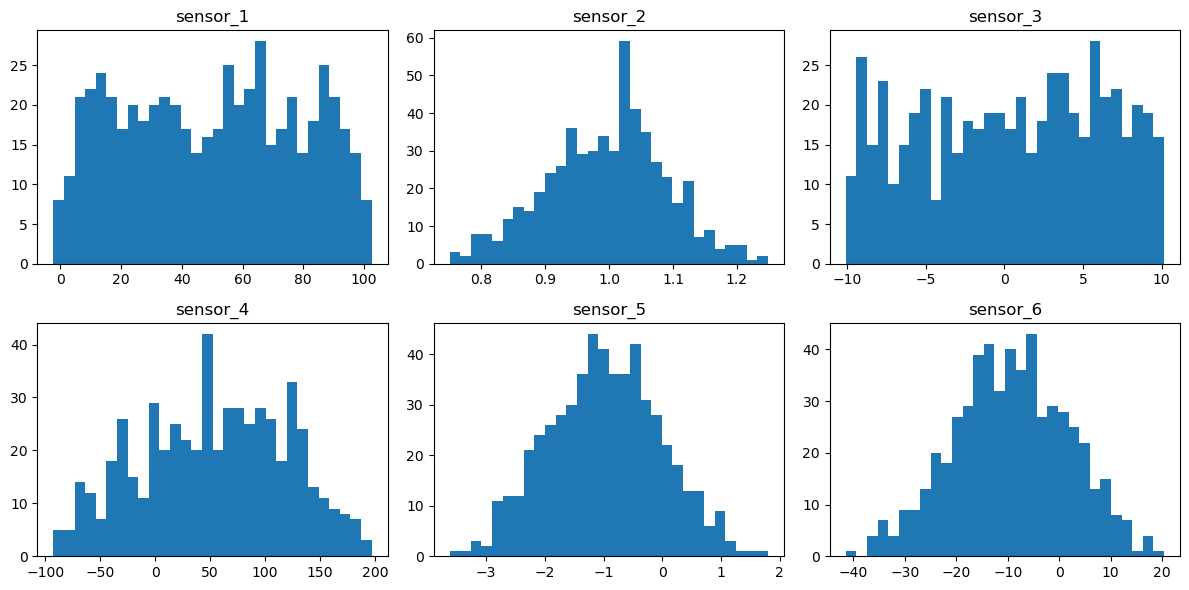

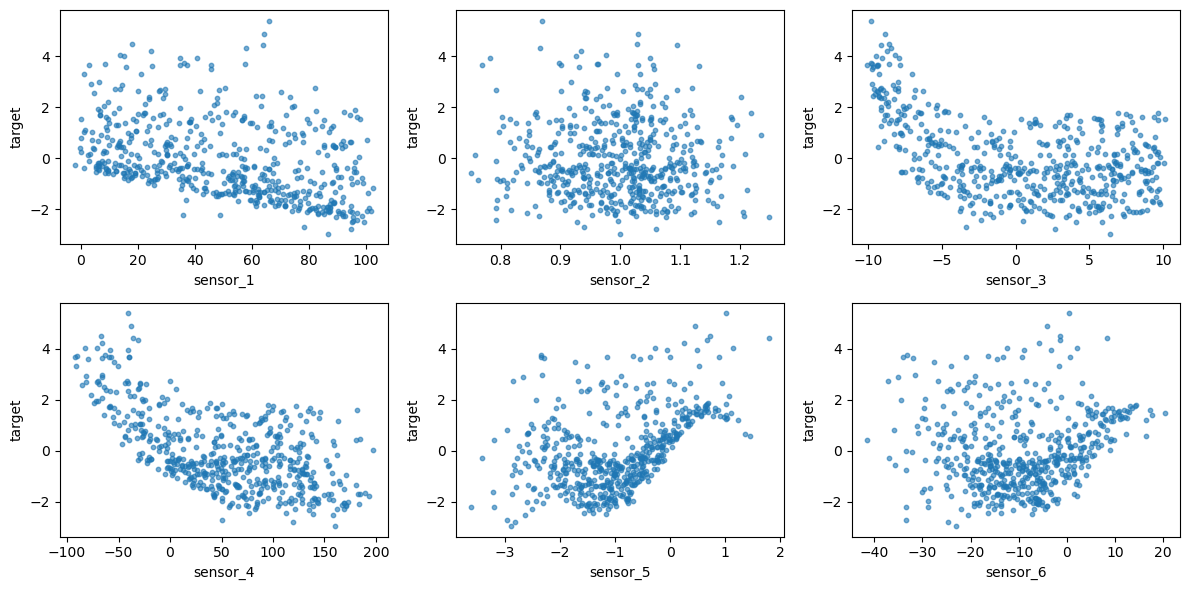

In [9]:
import matplotlib.pyplot as plt

# histograms
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, ax in enumerate(axes.ravel()):
    ax.hist(X_train[:, i], bins=30)
    ax.set_title(f"sensor_{i+1}")
plt.tight_layout()
plt.show()

# scatter each feature vs target
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, ax in enumerate(axes.ravel()):
    ax.scatter(X_train[:, i], y_train, s=10, alpha=0.6)
    ax.set_xlabel(f'sensor_{i+1}')
    ax.set_ylabel('target')
plt.tight_layout()
plt.show()
